### just trying to take a glance at Hi-C biases associated with allele1/2 to try to understand 2x difference in coverage

In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';    
        var cells = IPython.notebook.get_cells();    
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import gridspec
from matplotlib import colors

import os
import re
import numpy as np
import pandas as pd
import cooler

import itertools

import seaborn as sns

In [4]:
# cooltools used dekkerlab-fork, develop-branch, commit-af508bba9c6577b8271b716ba27c330bead15981
from cooler.tools import split, partition
from functools import partial
from cooltools import expected

import bioframe
from bioframe.io import resources
from bioframe import io

from cooltools import numutils
from cooltools.eigdecomp import cooler_cis_eig

In [5]:
from helper_module import fillcolor_compartment_style, to_uscs, bar_signal, random_test

In [6]:
cooler_names = [
    'all-allele-spe-2percent-highcis.galGal5.mapq_30.1000.mcool',
#     'all-allele-spe-1percent-highcis.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-16-2p-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
#     'MNP-DT40-1-3-16-R2-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-17-2p-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
#     'MNP-DT40-1-3-17-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-WT1-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-WT2-R1-T1__galGal5.galGal5.mapq_30.1000.mcool']

### generate some nicer sample names from coolers ...

In [7]:
# multiqc learnings here, btw!...
renamings = {"all-allele-spe":"pool",
            ".galGal5.mapq_30.1000.mcool":"",
            "MNP-DT40-":"",
            "-T1__galGal5":"",
            "-R1":"",
            "1-3-":"clone-"}

sample_names = []
for c in cooler_names:
    for rf,rt in renamings.items():
        c = re.sub(rf,rt,c)
    sample_names.append(c)

# sample_names

# form a df of samples here:
samples = pd.DataFrame({"sample":sample_names,"mcool":cooler_names})

samples

,sample,mcool
0,pool-2percent-highcis,all-allele-spe-2percent-highcis.galGal5.mapq_3...
1,clone-16-2p,MNP-DT40-1-3-16-2p-R1-T1__galGal5.galGal5.mapq...
2,clone-17-2p,MNP-DT40-1-3-17-2p-R1-T1__galGal5.galGal5.mapq...
3,WT1,MNP-DT40-WT1-R1-T1__galGal5.galGal5.mapq_30.10...
4,WT2,MNP-DT40-WT2-R1-T1__galGal5.galGal5.mapq_30.10...


### read some coolers and extract raw number of interactions between allele1/2 and other chromosomes ...

In [8]:
# READ SOME COOLERS ...
# oldref-20200617
cool_path = "/home/venevs/DOTS_TESTING/alv-chicken/oldref-20200617"
get_cpath = lambda c,b: os.path.join(cool_path,c+f"::/resolutions/{b}")

insertion_site = 72_500_000

dfs = {}
for s in samples["sample"]:
    _bsize = 1_000_000
    s_cname, = samples["mcool"][samples["sample"]==s]
    _c = cooler.Cooler(get_cpath(s_cname,_bsize))
    _df = pd.DataFrame(_c.chromsizes).reset_index().rename({"name":"chrom"},axis=1)
    a1_idx = _c.offset("allele1")
    a2_idx = _c.offset("allele2")
    chr1_idx = slice(*_c.extent("chr1"))
    # chr1_idx = _c.offset(("chr1",insertion_site,insertion_site+_bsize))
    _df["allele1"] = [np.sum(_c.matrix(balance=False)[a1_idx,slice(*_c.extent(chrom))]) for chrom in _c.chromnames]
    _df["allele2"] = [np.sum(_c.matrix(balance=False)[a2_idx,slice(*_c.extent(chrom))]) for chrom in _c.chromnames]
    _df["chr1"] = [np.sum(_c.matrix(balance=False)[chr1_idx,slice(*_c.extent(chrom))]) for chrom in _c.chromnames]
    dfs[s] = _df

### test GC content of allele1 and allele2, and "density" of DpnII cut-sites

In [33]:
gc_dict = {}
from Bio import SeqIO, SeqUtils
for seq in SeqIO.parse("galGal5.fa","fasta"):
    if seq.id in ["allele1","allele2"]:
        print(seq.id, SeqUtils.GC(seq.seq), len(seq))
        cuts = len(SeqUtils.nt_search(str(seq.seq),"GATC"))-1
        print(seq.id, "cutsites", cuts/len(seq) )
        gc_dict[seq.id] = {"GC":SeqUtils.GC(seq.seq),"length":len(seq),"cut":cuts/len(seq)}
    elif seq.id == "chr1":
        # print(seq.id, SeqUtils.GC(seq.seq[insertion_site-1_000_000:insertion_site+1_000_000]), len(seq))
        # only an estimate of cut sites in chr1 - only in the first 1Mb
        # otherwise it takes forever to calculate ...
        cuts = len(SeqUtils.nt_search(str(seq.seq)[:1_000_000],"GATC"))-1
        print(seq.id, SeqUtils.GC(seq.seq), len(seq))
        print(seq.id, "cutsites", cuts/1_000_000 )
        gc_dict[seq.id] = {"GC":SeqUtils.GC(seq.seq),"length":len(seq),"cut":cuts/1_000_000}
    else:
        pass
# allele1 is a bit more GC-rich

chr1 40.01674361571989 196202544
chr1 cutsites 0.002134
allele1 56.674565560821485 2532
allele1 cutsites 0.004344391785150079
allele2 46.15384615384615 2509
allele2 cutsites 0.0031885213232363493


In [10]:
s = samples["sample"][0]
_bsize = 50_000
s_cname, = samples["mcool"][samples["sample"]==s]
clr = cooler.Cooler(get_cpath(s_cname,_bsize))
print(s,clr.info)

pool-2percent-highcis {'bin-size': 50000, 'bin-type': 'fixed', 'creation-date': '2020-06-11T04:43:47.331890', 'format': 'HDF5::Cooler', 'format-url': 'https://github.com/mirnylab/cooler', 'format-version': 3, 'generated-by': 'cooler-0.8.1', 'genome-assembly': 'unknown', 'metadata': {}, 'nbins': 20433, 'nchroms': 37, 'nnz': 111179105, 'storage-mode': 'symmetric-upper', 'sum': 897082537}


In [12]:
binss = []
for seqrec in SeqIO.parse("galGal5.fa","fasta"):
    chrom = seqrec.id
    if chrom in clr.chromnames[:10]:
        bins = clr.bins().fetch(chrom)
        bins["GC"] = [ SeqUtils.GC(seqrec.seq[r.start:r.end])  for r in bins.itertuples()]
        bins["cut"] = [ len(SeqUtils.nt_search(str(seqrec.seq[r.start:r.end]),"GATC"))/(r.end-r.start) for r in bins.itertuples()]
        binss.append(bins) 
binss = pd.concat(binss)

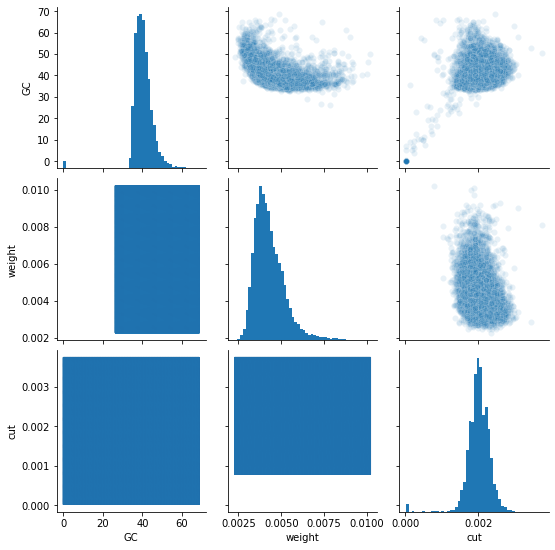

In [13]:
# sns.jointplot(data=binss,y="weight",x="GC",kind="hex", color="k");
g = sns.PairGrid(binss[["GC","weight","cut"]], diag_sharey=False)
g.map_upper(sns.scatterplot,**{"alpha":0.1})
g.map_lower(plt.hexbin ,gridsize=1000)#, **{"kind":"hex"})
g.map_diag(plt.hist, bins=50)

### let's estimate fraction of `cis` interactions for allele1/2

this is a rough estimate , calculated by summing raw allele1/2 interactions with chr1 and dividing by the total number of interactions detected with allele1/2

In [46]:
# construct a little table to characterize each sample allele1/allele2 interactions
df_dict = {}
for s in samples["sample"]:
    if "WT" not in s:
        df_dict[s] = {}
        df_dict[s]["allele1"] = {}
        df_dict[s]["allele2"] = {}
        df_dict[s]["chr1"] = {}

df_combo = []
for s in samples["sample"]:
    if "WT" not in s:
        dd = dfs[s]
        for ccc in ["allele1","allele2","chr1"]:
            df_dict[s][ccc]["total interactions"] = str(dd[ccc].sum())
            df_dict[s][ccc]["interactions w. chr1"] = str(dd[dd["chrom"]=="chr1"][ccc].sum())
            df_dict[s][ccc]["cis_percent"] = str(f'{100*dd[dd["chrom"].isin([ccc,"chr1"])][ccc].sum()/dd[ccc].sum():.2f}')
            df_dict[s][ccc]["GC"] = gc_dict[ccc]["GC"]
            df_dict[s][ccc]["DpnII sites/bp"] = gc_dict[ccc]["cut"]
            df_dict[s][ccc]["length"] = gc_dict[ccc]["length"]
            #
            _df = pd.DataFrame(df_dict[s]).T
            _df["sample"] = s
            df_combo.append(_df)
            
        
# allele1 seem to have more inter-chromosomal interactions
# allele2 have average level of interactions with other chromosomes - roughly as a whole chr1

dtypes = {"total interactions":int,
        "interactions w. chr1":int,
        "cis_percent":float,
        "GC":float,
        "length":int,
        }
# nice summary table about the samples/alleles :
final_df = pd.concat(df_combo) \
    .dropna() \
    .drop_duplicates() \
    .reset_index() \
    .rename({"index":"name"},axis=1) \
    .sort_values("name") \
    .reset_index(drop=True) \
    .astype(dtypes)

In [47]:
cols = ["name",
"length",
"GC",
"DpnII sites/bp",
"total interactions",
# "interactions w. chr1",
"cis_percent"]


print("clone-16-2p")
display( final_df[final_df["sample"] == "clone-16-2p"].reset_index(drop=True)[cols] )
print("clone-17-2p")
display( final_df[final_df["sample"] == "clone-17-2p"].reset_index(drop=True)[cols] )

clone-16-2p


,name,length,GC,DpnII sites/bp,total interactions,cis_percent
0,allele1,2532,56.674566,0.00434439,2433,67.41
1,allele2,2509,46.153846,0.00318852,1318,80.20
2,chr1,196202544,40.016744,0.002134,121564119,81.08


clone-17-2p


,name,length,GC,DpnII sites/bp,total interactions,cis_percent
0,allele1,2532,56.674566,0.00434439,2369,69.78
1,allele2,2509,46.153846,0.00318852,1290,78.53
2,chr1,196202544,40.016744,0.002134,116517761,80.63
